In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
import os
import numpy as np
from peewee import fn
from dr_path.db import models, io
from dr_path import settings
from dr_path.futures.pathways import build_supply_curve
from collections import OrderedDict
from pandas.api.types import CategoricalDtype
from multiprocessing import cpu_count
from dr_path.plotting import plots
from dr_path.plotting import plot_settings
import re
from plotnine import *

In [60]:
pwd

'/home/smurthy2/DR-Path/dr-path/postprocessing'

In [2]:
import warnings
warnings.filterwarnings('ignore', module='plotnine')

In [3]:
test_year = max([y[0] for y in settings.YEAR_CHOICES])

In [4]:
#Filter only the db files from the tech_inputs folder
db_list = [d for d in os.listdir(settings.OUTPUT_DIR) if re.search(r'\d+(.db)$',d)]

In [5]:
db_list = sorted(db_list)

In [6]:
db_list

['dr_path_NENG_0.db',
 'dr_path_NENG_1.db',
 'dr_path_NENG_2.db',
 'dr_path_NENG_3.db',
 'dr_path_NENG_4.db',
 'dr_path_NENG_5.db']

In [7]:
scenario = ['Baseline','Equipment Upgrades','Controls Upgrade','Envelope','Controls and Envelope','All']

In [8]:
cores = cpu_count()-1

In [9]:
shed_df = pd.DataFrame()
for i,db in enumerate(db_list):
    try:
        models.database.close()
    except:
        pass

    db_file = os.path.join(settings.OUTPUT_DIR, db)
    print(db_file,i)
    models.database.init(db_file)
    models.database.connect()
    #print('Database contains {} demand scenarios.'.format(models.DemandScenario.select().count()))
    #Clear out the existing site installations and incentive/adoption levels
    models.DRPathway.delete().execute()
    
    for y, foo in settings.YEAR_CHOICES:
        for dem in models.DemandScenario.select():
            for tou in models.TOUImpactScenario.select():
                for ren in models.RenewableScenario.select().where(models.RenewableScenario.weather==dem.weather):
                    for cost_frame in settings.COST_FRAMES:
                        for timescale in settings.TIMESCALES:
                            path_shed = build_supply_curve(dem, tou, ren, year=y, dr_type='shed', 
                                                            timescale=timescale, cost_frame=cost_frame[0], 
                                                            write_out=True, cores=cores)
    
    dem = models.DemandScenario.get(id=1)
    tou = models.TOUImpactScenario.get(id=1)
    ren = models.RenewableScenario.select().where(models.RenewableScenario.weather ==
                                          dem.weather)[0]
    ts = models.TechnologyScenario.get(name='Base')
    ds_df = plots.get_plot_data(dem, tou, ren, ts, year=test_year, timescale='year', 
                                dr_type='shed', disaggregate_by=['sector','end_use'])
    ds_df['EE_SCEN'] = i
    ds_df['scenario'] = scenario[i]
    shed_df = pd.concat([shed_df, ds_df])
    #plot_barchart = (shift_df/(1000**2)).plot.barh(stacked=True)
    #lines, labels = plot_barchart.get_legend_handles_labels()
    #plot_barchart.legend(bbox_to_anchor=(1.0,1.0))
    #plt.xlabel("'Shift DR potential (GWh-year)'")
    #plt.ylabel("Procurement Price ($/kWh-year)")
    #plt.show()
    models.database.close()   

/home/smurthy2/DR-Path/dr_path_inputs_resstock/NENG/dr_path_NENG_0.db 0
/home/smurthy2/DR-Path/dr_path_inputs_resstock/NENG/dr_path_NENG_1.db 1
/home/smurthy2/DR-Path/dr_path_inputs_resstock/NENG/dr_path_NENG_2.db 2
/home/smurthy2/DR-Path/dr_path_inputs_resstock/NENG/dr_path_NENG_3.db 3
/home/smurthy2/DR-Path/dr_path_inputs_resstock/NENG/dr_path_NENG_4.db 4
/home/smurthy2/DR-Path/dr_path_inputs_resstock/NENG/dr_path_NENG_5.db 5


In [10]:
scenario = ['All', 'Controls and Envelope', 'Envelope', 'Controls Upgrade', 'Equipment Upgrades', 'Baseline']

In [11]:
shed_camx = pd.read_csv('Shed_CAMX.csv')
shed_erct = pd.read_csv('Shed_ERCT.csv')
shed_neng = pd.read_csv('Shed_NENG.csv')

In [12]:
shed_camx['region'] = 'CAMX'
shed_erct['region'] = 'ERCT'
shed_neng['region'] = 'NENG'

In [13]:
shed = pd.concat([shed_camx, shed_erct, shed_neng])

In [14]:
end_uses = ['Water heating', 'Pool Pumps', 'Dishwashers', 'Clothes Dryers', 'Refrigeration', 'Space heating', 'Space cooling', 'Clothes Washers']
shed['scenario'] = pd.Categorical(shed['scenario'], categories=scenario, ordered=True) 
shed['end_use'] = pd.Categorical(shed['end_use'], categories=end_uses, ordered=True)

In [15]:
dr_type = 'Shed'
colors = ["salmon", "lightgreen", "green", "gold", "steelblue", 'darkorange', 'lightblue', 'red']

/home/smurthy2/.local/share/virtualenvs/dr-path-mCw2uIkG/lib/python3.6/site-packages/mizani/bounds.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x == -np.inf] = range[0]
/home/smurthy2/.local/share/virtualenvs/dr-path-mCw2uIkG/lib/python3.6/site-packages/mizani/bounds.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x == np.inf] = range[1]
/home/smurthy2/.local/share/virtualenvs/dr-path-mCw2uIkG/lib/python3.6/site-packages/mizani/bounds.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

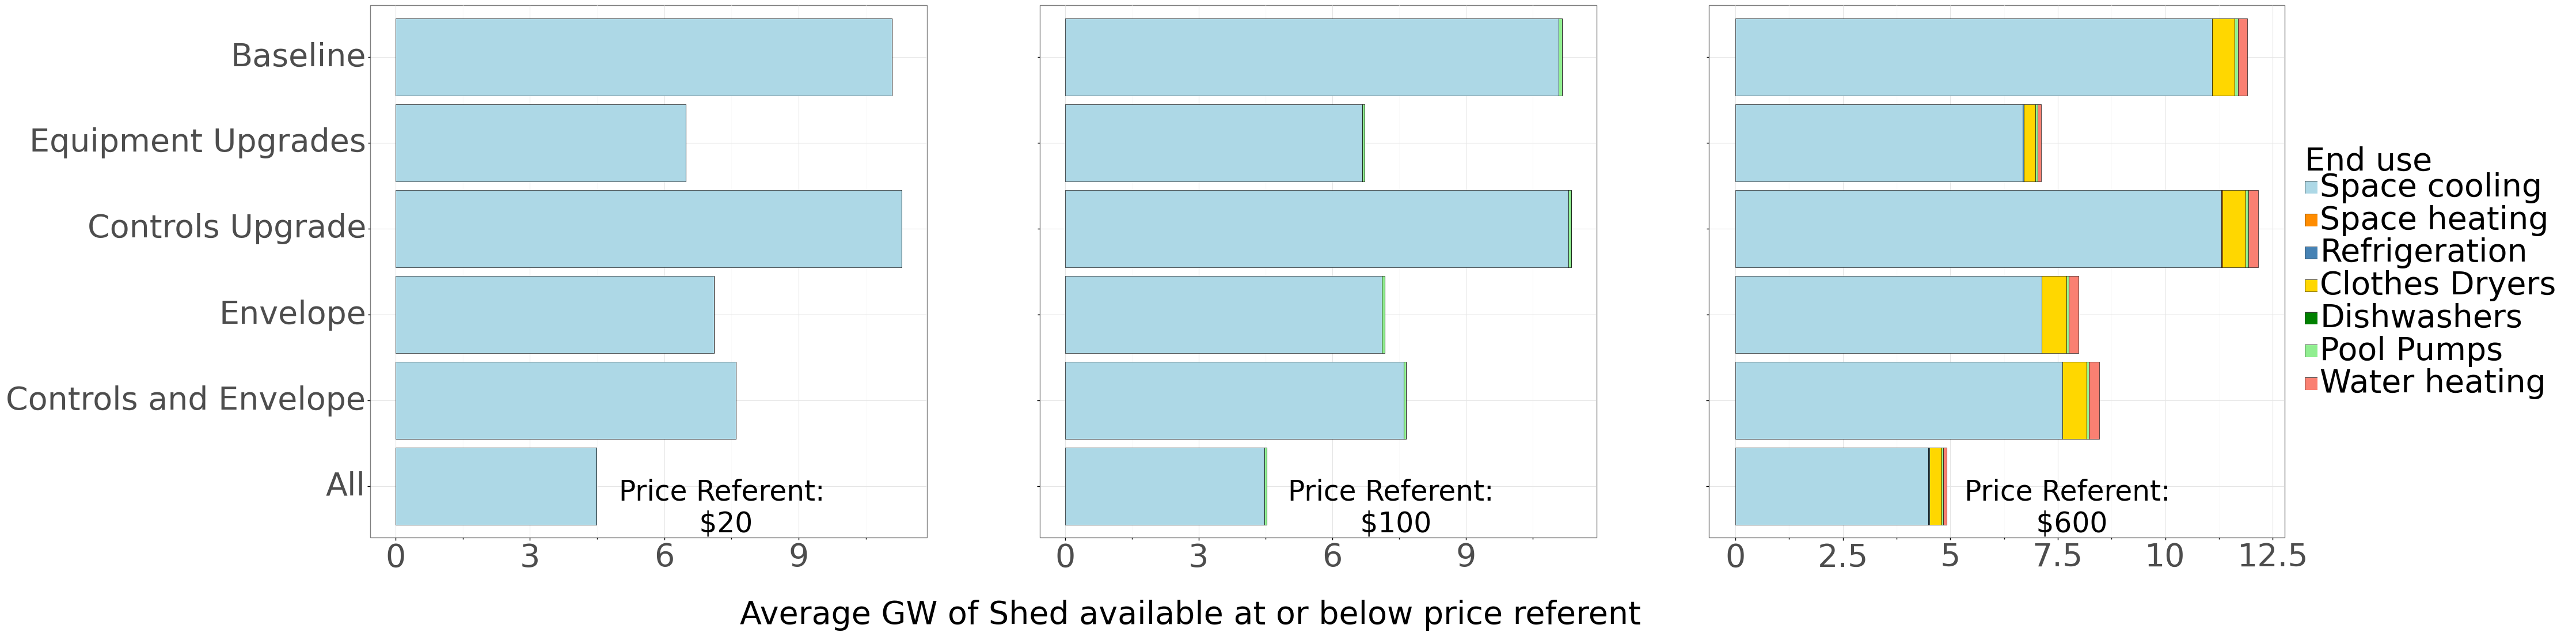

In [59]:
# Create subplots using plotnine
max_price_1=20
max_price_2=100
max_price_3=600
shed_camx = shed[shed['region']=='ERCT']
p1 = plot_barcharts(dem, tou, ren, ts,
                    plot_data=shed_camx,
                    bar_by='scenario', ylabel='scenario',
                    fill_by='end_use', max_price= max_price_1, bar_colors=colors
                    )

p2 = plot_barcharts(dem, tou, ren, ts,
                    plot_data=shed_camx,
                    bar_by='scenario', 
                    fill_by='end_use', max_price=max_price_2, bar_colors=colors
                    )
p3 = plot_barcharts(dem, tou, ren, ts,
                    plot_data=shed_camx,
                    bar_by='scenario',
                    fill_by='end_use', max_price=max_price_3, bar_colors=colors
                    )

# Empty plotnine figure to place the subplots on. Needs junk data (for backend "copy" reasons).
fig = (ggplot()+geom_blank(data=shed_df.sort_values('scenario'))+
       theme_void()+
       theme(subplots_adjust={'right': 1.1})+
       theme(figure_size=(12,6))+
       theme(subplots_adjust={'right': 1})+
       xlab('\n\nAverage GW of {t} available at or below price referent'.format(t=dr_type.capitalize()))
       ).draw()
fig.set_size_inches(38, 12, forward=True)
# Create gridspec for adding subpanels to the blank figure
gs = gridspec.GridSpec(1,3, width_ratios=[3, 3, 3.1])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

# Add subplots to the figure
_ = p1._draw_using_figure(fig, [ax1])
_ = p2._draw_using_figure(fig, [ax2])
_ = p3._draw_using_figure(fig, [ax3])


fig.show()
#ggsave(fig, "Price_referent_plots_{p}".format(p=max_price), dpi=300)
fig.savefig('Price_referent_plots_Shed_{r}_X_random.png'.format(r='ERCT'), dpi=300, bbox_inches='tight', pad_inches=0)

In [57]:
def plot_barcharts(
    *args, bar_by, plot_data=None, ylabel=None,xlabel=None,facet_by=False,
    fill_by=False, max_price=1000, ncol=None,
    position='stack', figure_size=(12,6), text_size=40,
    bar_colors=None, bar_cmap=('tab20',20), 
    **kwargs):
    '''
    Plots a DR-Path supply curve, disaggregated across various dimensions, 
    as allowed by io.get_supply_curve.
    
    Arguments:
    ----------
    *args: Accepts exactly the same arguments as io.get_supply_curve. These are:
        ds, tou, ren, tech: DemandScenario, TOUImpactScenario, 
                            RenewableSceanrio and TechnologyScenario 
                            objects, respectively
    bar_by: Dimension to use to create categories for the bars in the bar
        chart. Required.
    Keyword Arguments:
    ------------------
    fill_by: Dimension by which to create stacked (or grouped) bars with different 
        fill colors.
    facet_by: Dimension by which to disaggregate into facet plots.
    x/y_label: Create your own x/y axis label, to override defaults
    figure_size: Tuple containing the desired figure size (x_size, y_size)
    text_size: Text size in figure.
    max_price: Maximum procurement price at which to plot the available resource.
    ncol: This variable defines how many columns will be in the facet plot. 
    position: This variable either groups the fill_by variables (use 'dodge'), or 
        stacks them (default).
    bar_colors: Explicit matplotlib color specifications to 
        be used for the bar fill colors. The user must ensure
        that the number of colors passed is the same as the number of 
        elements to be filled, otherwise this will not work as expected.
    bar_cmap: Color map for the bar fill colors. Ignored if 
        bar_colors is specified. This should be passed as a tuple of form 
        (name, ncol), where
        * name is the name of the matplotlib color map to use for the 
              stacked bar plots.
        * ncol is an integer representing the number of color gradations
              assumed to be in the color map.
    **kwargs: pass through to 
    '''
    
    #Set up some labeling information
    ref_price_text='price referent'
    try:
        dr_type=kwargs['dr_type']
    except:
        dr_type='shed'
    if dr_type=='shift':
        res_unit = 'GWh'
        price_unit = 'yr/kWh'
    else:
        res_unit = 'GW'
        price_unit = 'yr/kW'
    
    
    if plot_data is None:    
        ref_price_text='${p}/{u}'.format(p=max_price, u=price_unit)

        #Build disaggregation list
        disagg = []
        if facet_by: disagg += [facet_by]
        if fill_by and (fill_by not in disagg): disagg+= [fill_by]
        if bar_by and (bar_by not in disagg): disagg+= [bar_by]
        plot_data = get_plot_data(*args, disaggregate_by=disagg, **kwargs)
        #Get the highest price that is less than the input price
        chosen_price = plot_data.loc[plot_data['procurement_price']<=max_price, 
                                     'procurement_price'].max()
        #Now pick out the data where the procurement price is equal to the chosen price
        plot_data = plot_data.loc[plot_data['procurement_price']==chosen_price]
    
    plot_data = plot_data.copy().loc[plot_data['procurement_price']==max_price]
       
    
    #build the appropriate aesthetic mappings
    if fill_by:
        plot_aes = aes(y='value', x=bar_by, fill=fill_by)
    else:
        plot_aes = aes(y='value', x=bar_by)
        #Y axis of geom_bar will always just be the bar_by dimension.
    
    #Begin building plot
    
    g = (ggplot(plot_data))
    g += geom_bar(plot_aes, color='black', size=0.25, stat='identity', position=position)
    
    #Add color map
    if fill_by:
        bars = list(plot_data[fill_by].unique().sort_values(ascending=False))
        nbars=len(bars)
        if bar_colors is not None:
            fill_colors=bar_colors
        else:
            fill_colors = [colors.to_hex(plt.get_cmap(bar_cmap[0])(i)) 
                           for i in np.arange(nbars)/(bar_cmap[1])%1]

        g = g+scale_fill_manual(fill_colors, breaks=bars, name=plots.strip_and_cap(fill_by))

    region=plot_data['region'].unique().astype(str)
    reg=''
    region = reg.join(region)
    x_scale = (plot_data[(plot_data['procurement_price']==max_price) & (plot_data[bar_by]=='All')].value.sum()+2.8)
    #Add theme
    g += theme_bw()
    g += theme(figure_size=figure_size)
    g += theme(text = element_text(size=text_size))
    g += annotate('text', x=0.75, y=x_scale, label='Price Referent:\n $'+str(max_price), size=35)

    
    if facet_by:
            #Divide into facets
            n_facets = plot_data[facet_by].nunique()
            g += facet_wrap(facet_by, ncol=ncol) 
    #Finishing plot elements
    g = g + coord_flip()
    #g += scale_y_continuous(breaks=np.arange(0, 13), labels=['0', '1', '2', '3',
     #                                                        '4', '5', '6', '7',
      #                                                      '8', '9', '10', '11', '12'],expand=(0, 0.1, 0.1, 0))
    
    #Set appropriate axis labels
    xlabel = 'Average {u} of {t} available at or below {p}'.format(
        u=res_unit, t=dr_type.capitalize(), p=ref_price_text)
    if ylabel: g = g+ylab(ylabel)+xlab(xlabel)
    else: 
        g +=theme(axis_text_y=element_blank())
        g = g + xlab(xlabel)
    #if dr_type=='shift':
    #    if not xlabel: 
    #        xlabel = 'GWh-yr of {t} DR available at or below ${p}/kWh-yr'.format(
    #            t=dr_type.capitalize(), p=str(max_price))
    #else:
    #    if not xlabel: 
    #        xlabel = 'GW-yr of {t} DR available at or below ${p}/kW-yr'.format(
    #            t=dr_type.capitalize(), p=str(max_price))

    return g

In [364]:
np.arange(0,5)

array([0, 1, 2, 3, 4])